## Linear Regression For Pricing Analysis

Given is the dataset `airbnb1.csv` which includes all Airbnb accommodations from Berlin. Besides a list of properties of the apartment, the price per night (in the column `price`) is provided.

In [1]:
import pandas as pd

# Read dataset
airbnb = pd.read_csv('../resources/airbnb1.csv')
airbnb.head()

,id,listing_url,amenities,price
0,3176,https://www.airbnb.com/rooms/3176,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",$90.00
1,3309,https://www.airbnb.com/rooms/3309,"{Internet,Wifi,""Pets live on this property"",Ca...",$28.00
2,7071,https://www.airbnb.com/rooms/7071,"{Wifi,Heating,""Family/kid friendly"",Essentials...",$33.00
3,9991,https://www.airbnb.com/rooms/9991,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$180.00
4,14325,https://www.airbnb.com/rooms/14325,"{TV,Internet,Wifi,Kitchen,""Buzzer/wireless int...",$70.00


You want to understand whether there are features that have a high influence on the price of an apartment. For this purpose, you first bring the data into a well-structured format.

In [2]:
# Clean string and split by ',' to get dummies
amenities = (
    airbnb.amenities
    .str.strip('{}')
    .str.replace('"', '', regex=False)
    .str.replace(';', '', regex=False)
    .str.replace(r',(?=[^ ]+)', ';', regex=True)
    .str.get_dummies(';')
)

# Strip columns and sort alphabetically
amenities.columns = amenities.columns.str.strip()
amenities.sort_index(axis=1, inplace=True)

# Concat with price column
amenities['price'] = airbnb.price
amenities.price = amenities.price.str.replace(r"\$|,", "", regex=True).astype(float)

amenities.head()

,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Baking sheet,...,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,price
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,90.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,28.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,33.0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,180.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,70.0


Then you look at the relative frequency of the properties, i.e. how many % of the apartments possess the respective property. At this point, you already exclude all properties that occur in less than 10% or in more than 90% of all apartments. You do not want to consider these properties in your regression equation anyway.

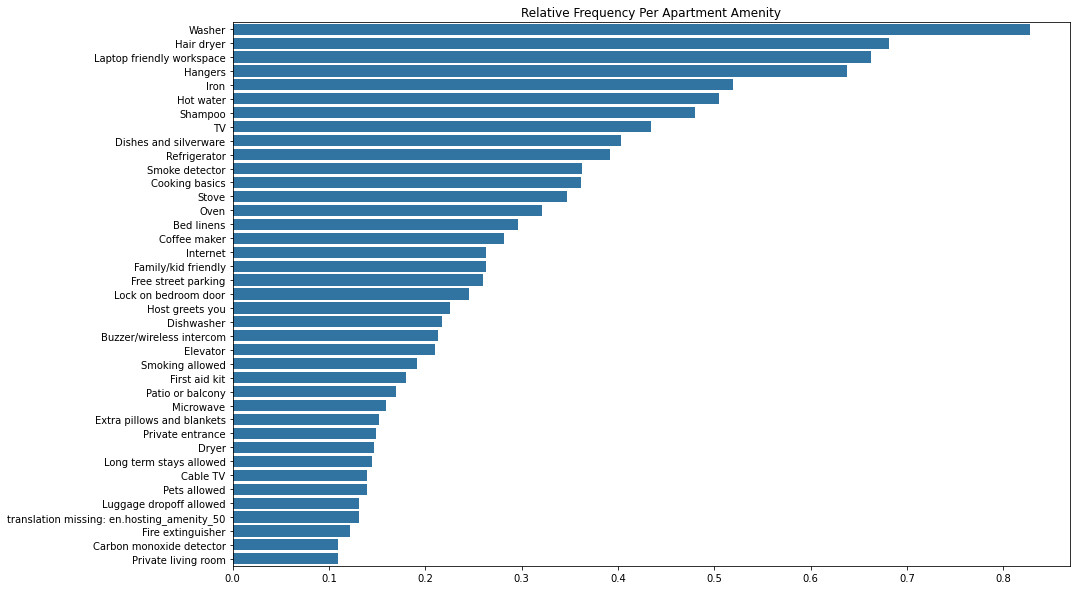

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get table of relative frequencies
amenities_freqs = amenities.drop('price', axis=1).mean(axis=0).sort_values(ascending=False)

# Filter to relevant amenities (relative frequency between 10% and 90%)
amenities_freqs = amenities_freqs[(amenities_freqs>0.10) & (amenities_freqs<0.90)]

# Create barplot
plt.figure(figsize=(15, 10))
plt.title("Relative Frequency Per Apartment Amenity")
sns.barplot(x = amenities_freqs.values, y = amenities_freqs.index, color='C0')
plt.show()

Now you perform a linear regression to estimate the influence of the above properties on the price per night. You then visualize the regression coefficients and additionally provide the R2 of the model.

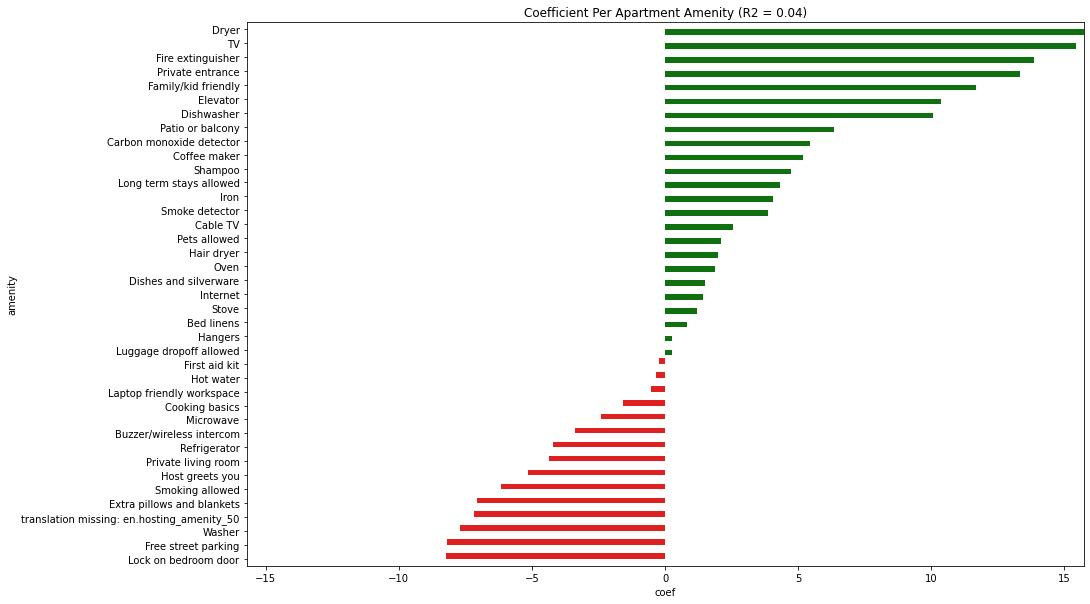

In [4]:
from sklearn.linear_model import LinearRegression

# Create feature matrix and target vector
X = amenities[amenities_freqs.index]
y = amenities.price

# Fit regression and get coefficients
lr = LinearRegression()
lr.fit(X, y)
coefs = pd.DataFrame({
    "amenity": X.columns,
    "coef": lr.coef_
}).sort_values('coef', ascending=False)

# Create barplot
plt.figure(figsize=(15, 10))
plt.title(f"Coefficient Per Apartment Amenity (R2 = {lr.score(X, y):.2f})")
sns.barplot(x = coefs.coef, y = coefs.amenity, hue=coefs.coef>0, palette=['red', 'green'])
plt.xlim([-coefs.coef.abs().max(), coefs.coef.abs().max()])
plt.legend().remove()
plt.show()

Some of the results do not seem very plausible to you. For example, the presence of parking spaces (`Free street parking`) is supposed to have a negative effect on the price. Why is the interpretation of the results difficult?

You come to the conclusion that you should add more variables to the regression model in order to measure the influence of apartment amenities on the price. For example, free street parking might be a feature that is more common in the suburbs of Berlin than in the city center. At the same time, apartments in the outer districts have a lower price, which could explain the negative coefficient of the `Free street parking` variable in the model from above. Your goal should be to incorporate all variables that show a correlation with both the apartment amenities and the apartment price.

You create the dataset `airbnb2.csv`, which contains - besides the previously encoded apartment properties and the cleaned apartment price - five additional variables:
* `host_since` - registration date of host
* `neighbourhood` - city district
* `room_type` - room type (whole apartment, private room, shared room)
* `guests_included` - number of guests included in the price
* `total_amenities` - the total number of all apartment amenities

In [5]:
# Read dataset
airbnb = pd.read_csv('../resources/airbnb2.csv')
airbnb.head()

,id,listing_url,host_since,neighbourhood,room_type,guests_included,total_amenities,Bed linens,Buzzer/wireless intercom,Cable TV,...,Private living room,Refrigerator,Shampoo,Smoke detector,Smoking allowed,Stove,TV,Washer,translation missing: en.hosting_amenity_50,price
0,3176,https://www.airbnb.com/rooms/3176,2008-10-19,Prenzlauer Berg,Entire home/apt,2,13,0,1,0,...,0,0,1,1,0,0,0,1,0,90.0
1,3309,https://www.airbnb.com/rooms/3309,2008-11-07,Schöneberg,Private room,1,18,1,1,0,...,0,0,1,1,0,0,0,1,1,28.0
2,7071,https://www.airbnb.com/rooms/7071,2009-05-16,Prenzlauer Berg,Private room,1,11,1,0,0,...,0,1,1,0,0,0,0,0,1,33.0
3,9991,https://www.airbnb.com/rooms/9991,2009-08-25,Prenzlauer Berg,Entire home/apt,5,23,1,1,1,...,0,1,0,1,0,1,1,1,0,180.0
4,14325,https://www.airbnb.com/rooms/14325,2009-11-18,Prenzlauer Berg,Entire home/apt,1,11,0,1,0,...,0,0,0,1,0,0,1,1,0,70.0


And again you prepare the data for the regression in the first step. You transform the variable `host_since` in a duration in years and perform an encoding of the variables `neighborhood` and `room_type`. 

Hints:
* Do not forget to exclude one encoded apartment amenity from the equation. Otherwise you run into a multicollinearity problem because of the additional variable `total_amenities`.
* For the variable `guests_included` there are 20 observations with missing values. You may simply exclude the observations for this exercise.

In [6]:
# Transform host_since column so that it gives weeks since registration
airbnb['host_since_years'] = (
    pd.Timestamp.now() - pd.to_datetime(airbnb['host_since'], dayfirst=True)
).dt.days / 365

# One hot encode neighborhood variable
neighborhood = pd.get_dummies(airbnb.neighbourhood)

# One hot encode room type variable
roomtype = pd.get_dummies(airbnb.room_type)

# Concat original data
airbnb_clean = pd.concat([
    airbnb[['host_since_years', 'guests_included', 'total_amenities']], 
    roomtype, 
    neighborhood, 
    airbnb.drop(
        ['id', 'listing_url', 'host_since', 'host_since_years', 'neighbourhood', 
         'room_type', 'guests_included', 'translation missing: en.hosting_amenity_50'], axis=1)
], axis=1)

# Drop observations with missing values
airbnb_clean.dropna(axis=0, inplace=True)

airbnb_clean.head()

,host_since_years,guests_included,total_amenities,Entire home/apt,Private room,Shared room,Adlershof,Alt-Hohenschönhausen,Alt-Treptow,Altglienicke,...,Private entrance,Private living room,Refrigerator,Shampoo,Smoke detector,Smoking allowed,Stove,TV,Washer,price
0,12.868493,2,13,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,90.0
1,12.816438,1,18,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,28.0
2,12.295890,1,11,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,33.0
3,12.019178,5,23,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,1,180.0
4,11.786301,1,11,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,70.0


Now you again perform a regression and visualize the model coefficients.

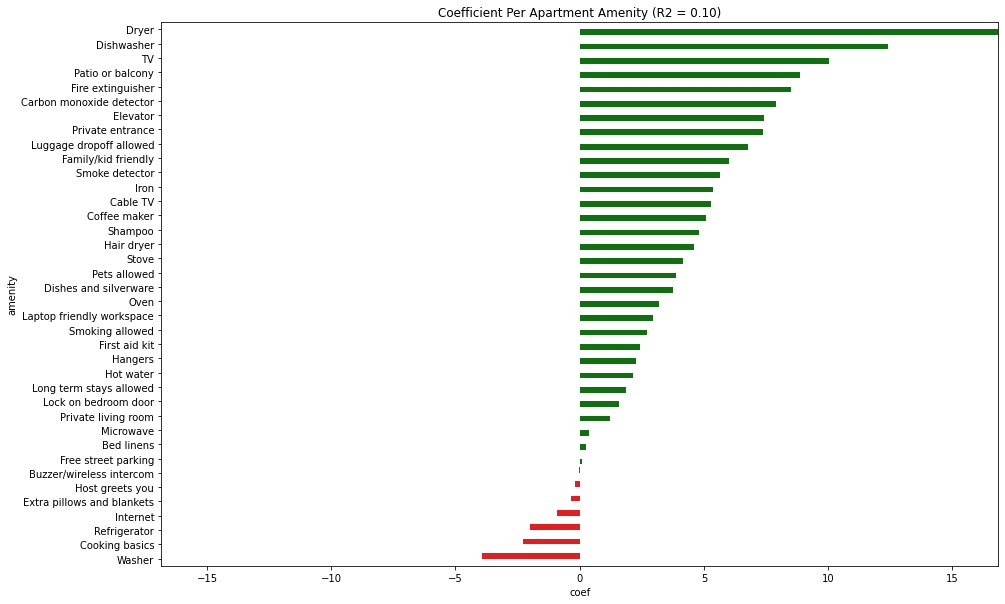

In [7]:
# Create feature matrix and target vector
X = airbnb_clean.drop('price', axis=1)
y = airbnb_clean.price

# Fit regression and get coefficients
lr = LinearRegression()
lr.fit(X, y)
coefs = pd.DataFrame({
    "amenity": X.columns,
    "coef": lr.coef_
}).sort_values('coef', ascending=False)

# Filter coefs to amenities
coefs = coefs[coefs.amenity.isin(amenities_freqs.index)]

# Create barplot
plt.figure(figsize=(15, 10))
plt.title(f"Coefficient Per Apartment Amenity (R2 = {lr.score(X, y):.2f})")
sns.barplot(x = coefs.coef, y = coefs.amenity, hue=coefs.coef>0, palette=['red', 'green'])
plt.xlim([-coefs.coef.abs().max(), coefs.coef.abs().max()])
plt.legend().remove()
plt.show()

This looks better at first sight. For example, the negative coefficient of the `Free street parking` feature has almost disappeared due to the inclusion of the new features. Can you trust the coefficients now?

An interpretation is still difficult due to at least three reasons: 

1. It might be that we still forgot variables that are a determinant of apartment price and correlated with one or more independent variables. In this case there is a so-called ommited variable bias in our estimates. 

2. It is conceivable that at least a few regression variables are strongly correlated with each other. This makes the estimation of the regression coefficients unstable and a statistical inference difficult. 

3. It is generally advisable to consider the uncertainty of the estimates, too. For example, by looking at confidence intervals, we would be able to make more informed interpretations.